# 주차 수요 예측

## 라이브러리 불러오기

In [359]:
from glob import glob 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib
import plotly.express as px 
import folium

## 컬럼 설명

train data column description :
- 단지코드(key)
- 총세대수
- 임대건물구분
- 지역
- 공급유형
- 전용면적
- 전용면적별세대수
- 공가수: 빈집
- 자격유형: 임차를 할 수 있는 자격 요건
- 임대료보증금
- 임대료
- 도보 10분거리 내 지하철역 수(환승노선 수 반영)
- 도보 10분거리 내 버스정류장 수
- 단지내주차면수
- 등록차량수(target)

## 데이터 불러오기

In [360]:
submission = glob('data/*.csv')[3]

In [361]:
test_file_name = glob('data/*.csv')[1]

In [362]:
train_file_name = glob('data/*.csv')[2]

In [363]:
train = pd.read_csv(train_file_name)

In [364]:
test = pd.read_csv(test_file_name)

In [365]:
train.shape, test.shape

((2952, 15), (1022, 14))

## 데이터 타입 

In [366]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2952 non-null   object 
 1   총세대수                          2952 non-null   int64  
 2   임대건물구분                        2952 non-null   object 
 3   지역                            2952 non-null   object 
 4   공급유형                          2952 non-null   object 
 5   전용면적                          2952 non-null   float64
 6   전용면적별세대수                      2952 non-null   int64  
 7   공가수                           2952 non-null   float64
 8   자격유형                          2952 non-null   object 
 9   임대보증금                         2383 non-null   object 
 10  임대료                           2383 non-null   object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2741 non-null   float64
 12  도보 10분거리 내 버스정류장 수            2948 non-null   float64
 13  단지내

In [367]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          1022 non-null   object 
 1   총세대수                          1022 non-null   int64  
 2   임대건물구분                        1022 non-null   object 
 3   지역                            1022 non-null   object 
 4   공급유형                          1022 non-null   object 
 5   전용면적                          1022 non-null   float64
 6   전용면적별세대수                      1022 non-null   int64  
 7   공가수                           1022 non-null   float64
 8   자격유형                          1020 non-null   object 
 9   임대보증금                         842 non-null    object 
 10  임대료                           842 non-null    object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  980 non-null    float64
 12  도보 10분거리 내 버스정류장 수            1022 non-null   float64
 13  단지내

In [368]:
train

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,C2532,239,아파트,강원도,국민임대,49.20,19,7.0,A,11346000,116090,0.0,1.0,166.0,146.0
2948,C2532,239,아파트,강원도,국민임대,51.08,34,7.0,A,14005000,142310,0.0,1.0,166.0,146.0
2949,C2532,239,아파트,강원도,국민임대,51.73,34,7.0,A,14005000,142310,0.0,1.0,166.0,146.0
2950,C2532,239,아파트,강원도,국민임대,51.96,114,7.0,A,14005000,142310,0.0,1.0,166.0,146.0


# 오류 1번 : 전용면적별 세대수 합계와 총세대수가 일치하지 않는 경우  

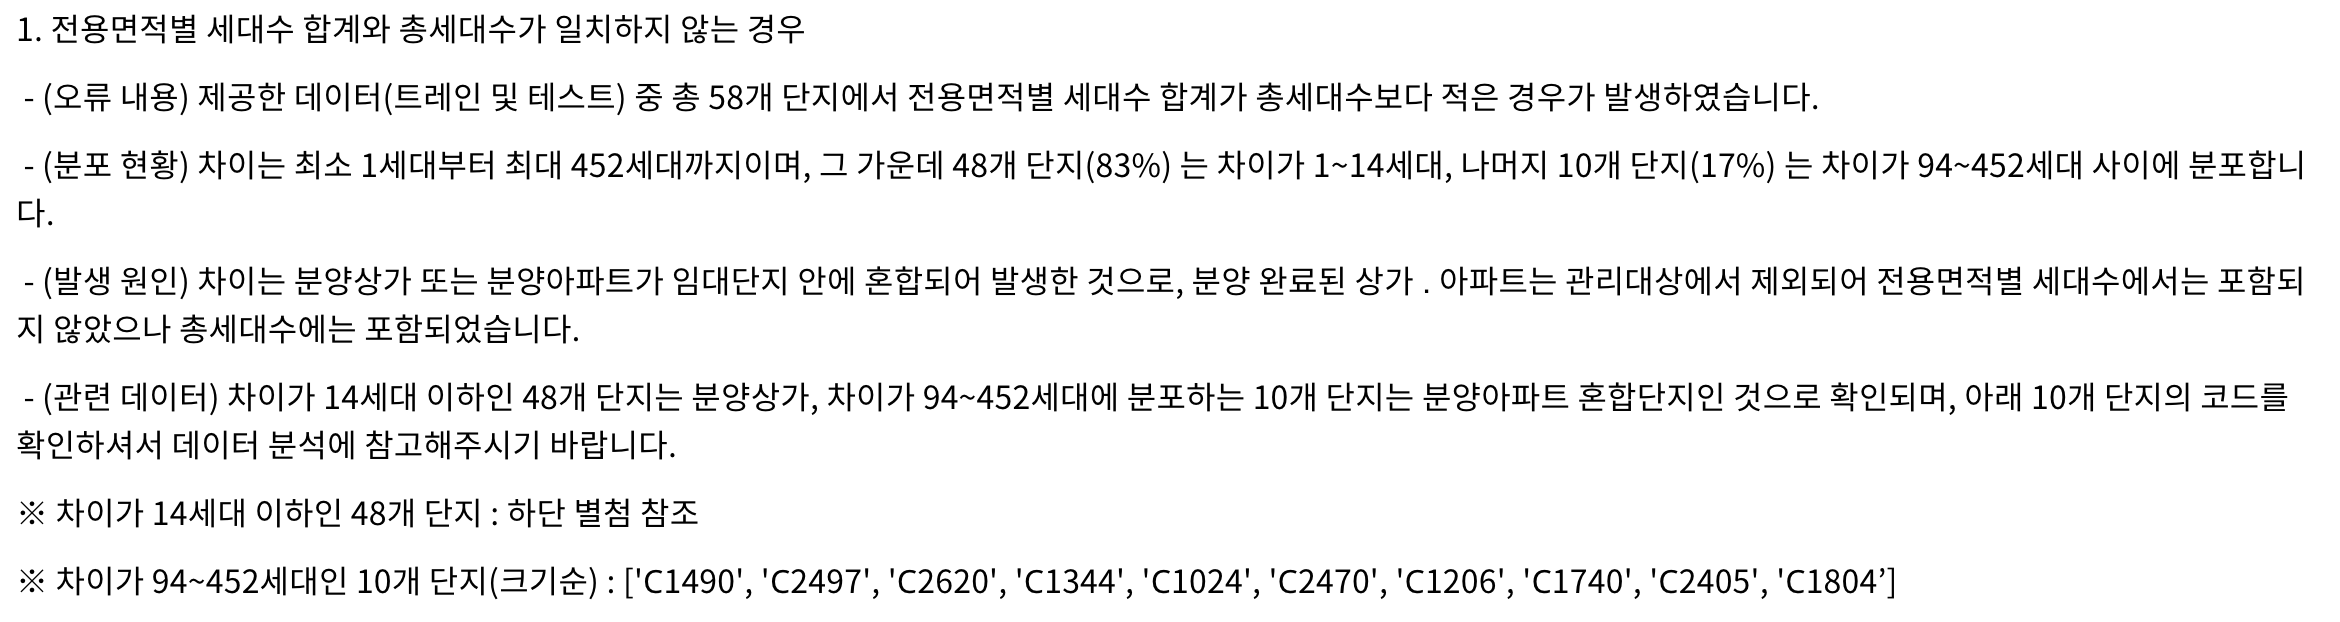

In [369]:
differ = train.groupby('단지코드').agg({'총세대수':'unique', '전용면적별세대수':'sum'})
differ['총세대수'] = differ['총세대수'].str[0].astype(int)
differ = differ[differ['총세대수'] != differ['전용면적별세대수']]
differ['차이'] = differ['총세대수'] - differ['전용면적별세대수']
differ

,총세대수,전용면적별세대수,차이
단지코드,,,
C1024,680,477,203
C1068,806,805,1
C1156,1004,998,6
C1206,755,488,267
C1218,1048,1040,8
C1312,518,517,1
C1344,424,300,124
C1424,625,624,1
C1490,749,655,94


Text(0.5, 1.0, '총세대수와 전용면적별 세대수 합계 차')

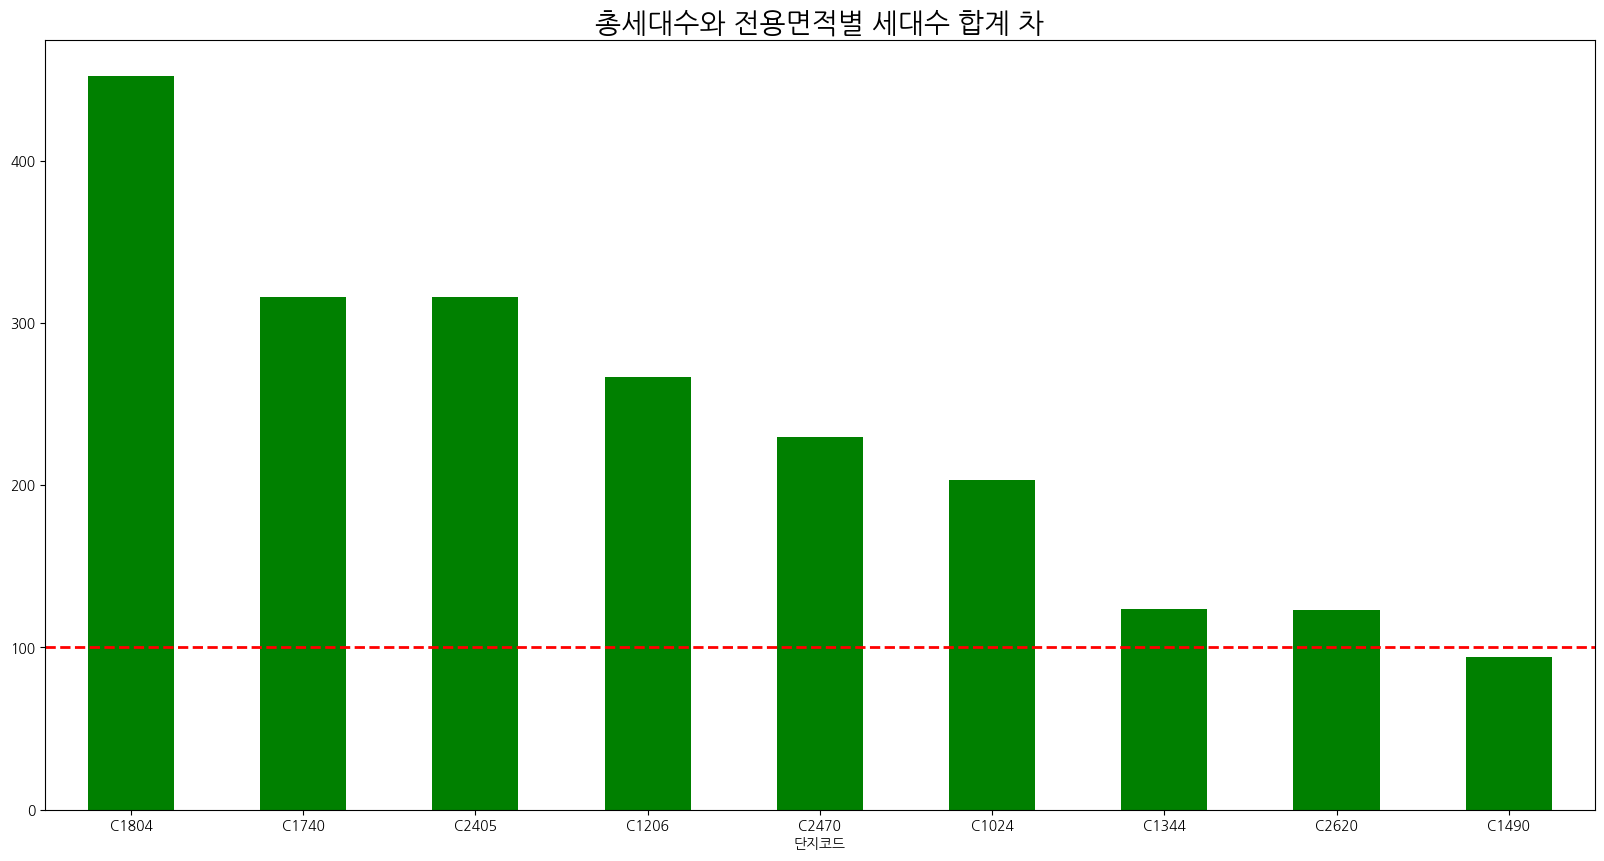

In [370]:
ax = differ.loc[differ['차이'] > 20, '차이'].sort_values(ascending=False).plot.bar(figsize=(20,10), color='Green', rot=0)
ax.axhline(y=100, color='r', linestyle='--', linewidth=2)
ax.set_title('총세대수와 전용면적별 세대수 합계 차', fontsize=20)


## 총세대수를 드랍하고 전용면적별세대수의 합계로 대체 

In [371]:
correct_train = train.groupby('단지코드').agg({'전용면적별세대수':'sum'})
train['총합계'] = train['단지코드'].map(correct_train['전용면적별세대수'])

In [372]:
correct_test = test.groupby('단지코드').agg({'전용면적별세대수':'sum'})
test['총합계'] = test['단지코드'].map(correct_test['전용면적별세대수'])

In [373]:
# 기존 세대수 column 삭제 and 컬럼 순서 조정 
train = train[['단지코드', '총합계', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수']]

In [374]:
# 기존 세대수 column 삭제 and 컬럼 순서 조정 
test = test[['단지코드', '총합계', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', '단지내주차면수']]

# 오류 2번 : 동일한 단지에 단지코드가 2개로 부여된 경우  



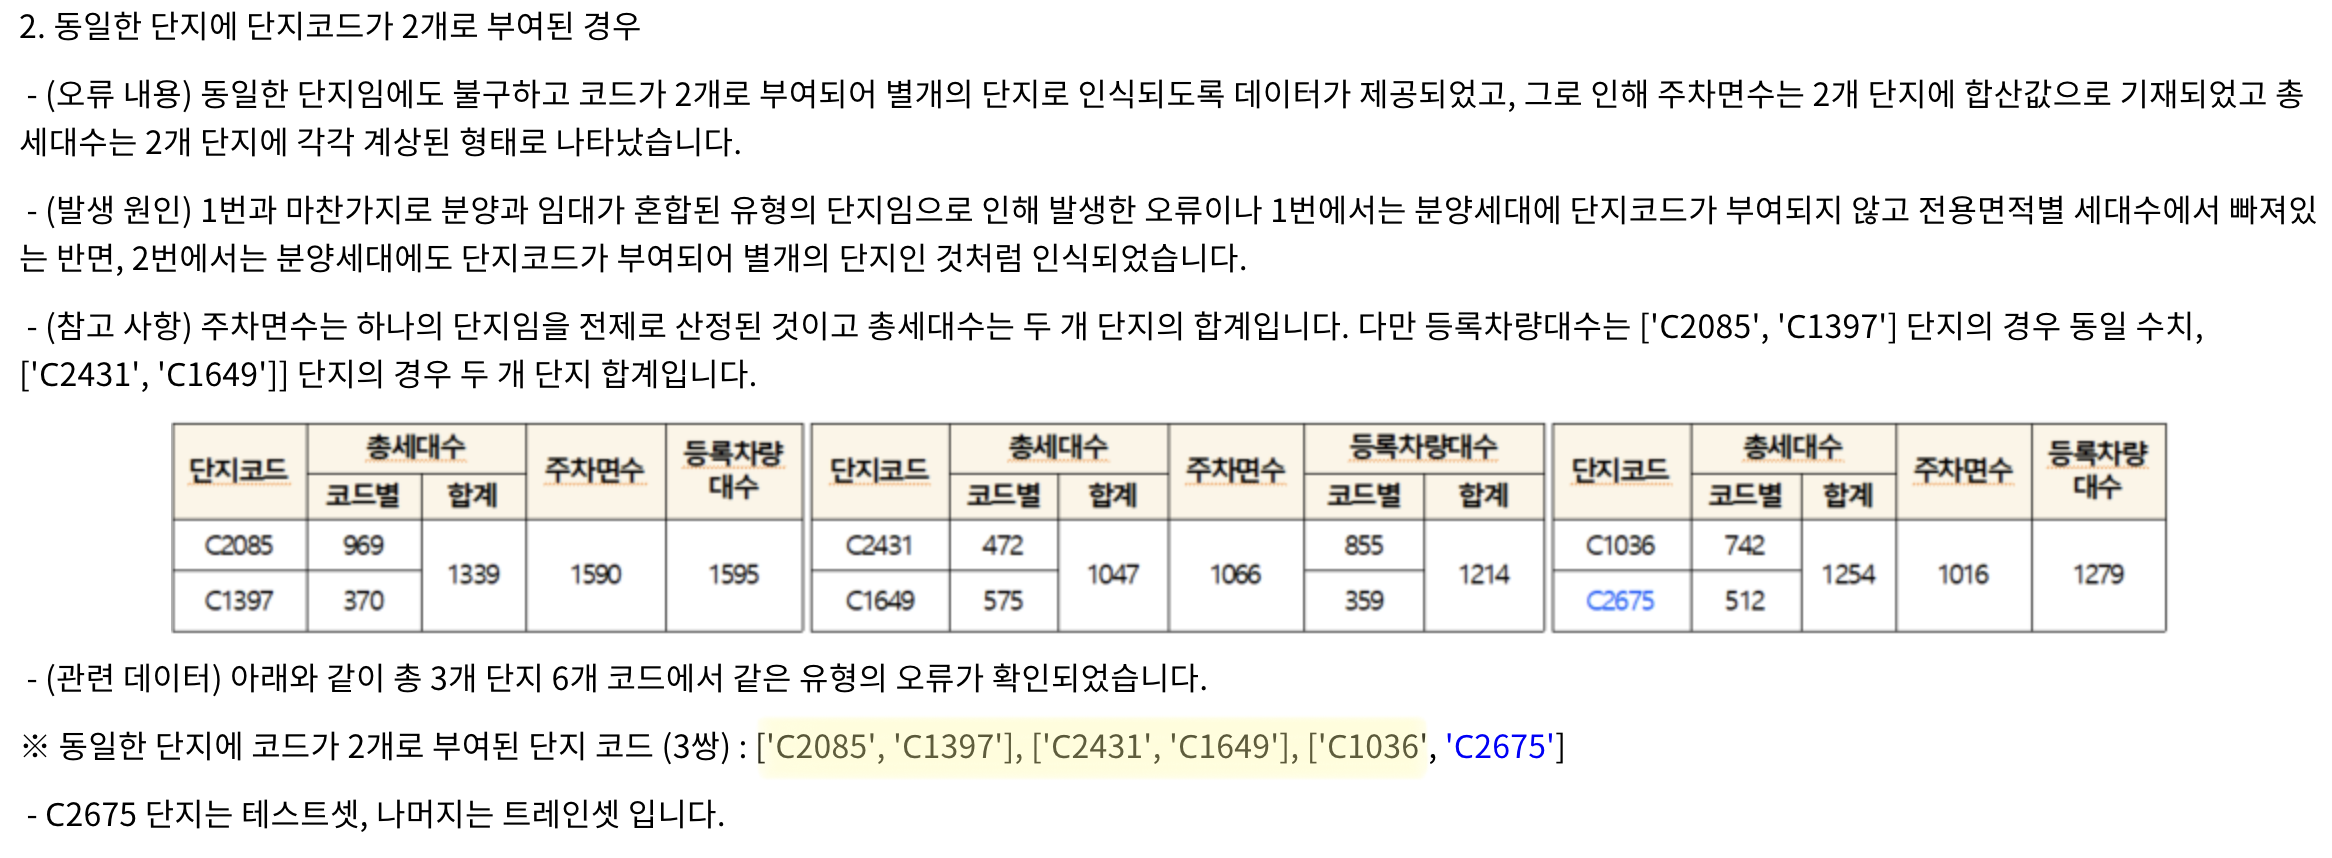

In [375]:
# 오류 2번 해당 train 데이터셋 제거
train = train[train['단지코드'] != 'C2085']
train = train[train['단지코드'] != 'C1397']
train = train[train['단지코드'] != 'C2431']
train = train[train['단지코드'] != 'C1649']
train = train[train['단지코드'] != 'C1036']

# 오류 3번 : 단지코드 등 기입 실수로 데이터 정제 과정에서 매칭 오류 발생  



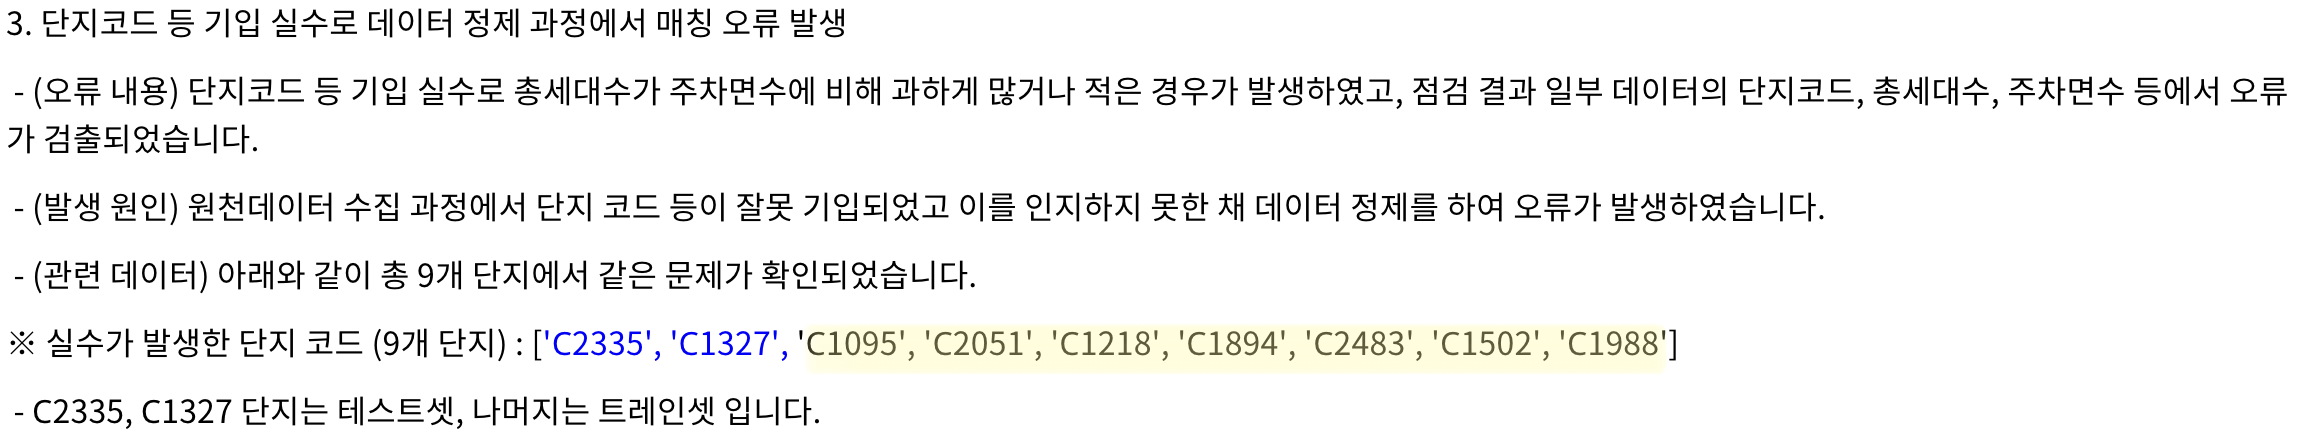

In [376]:
# 오류 3번 해당 train 데이터셋 제거
train = train[train['단지코드'] != 'C1095']
train = train[train['단지코드'] != 'C2051']
train = train[train['단지코드'] != 'C1218']
train = train[train['단지코드'] != 'C1894']
train = train[train['단지코드'] != 'C2483']
train = train[train['단지코드'] != 'C1502']
train = train[train['단지코드'] != 'C1988']

* 오류값 조정 후 shape 값 비교
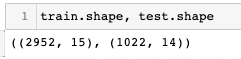

In [377]:
train.shape, test.shape

((2869, 15), (1022, 14))

# 결측치 확인

In [357]:
train.isnull().sum()

단지코드                              0
총합계                               0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           569
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)    207
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
등록차량수                             0
dtype: int64

In [358]:
## 결측치 확인

train.isnull().sum()

단지코드                              0
총합계                               0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           569
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)    207
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
등록차량수                             0
dtype: int64